# Applied Data Science by IBM

Capstone Project - The Battle of Neighborhoods (Week 2)

Introduction

Background: I am a freelance food blogger and I want to analyse the Indian Restaurant availability in the NY city and help my followers to get the details related to Indian Restaurant availability in different parts of NY city. 

Problem: This capstone project aims to explore the NY city to list and visualize the parts of the area which has some great Indian restaurants, potential market/area to open the Indian restaurant, the areas which has lack of Indian restaurants and which is the best place to live in NY city if you prefer Indian cuisines as well.


New York City's demographics show that it is a large and ethnically diverse metropolis. With its diverse culture, comes diverse food items. There are many restaurants in New York City, each belonging to different categories like Chinese, Indian, and Spanish etc.

To address this problem we need the following data: 
1. New York City data that contains list Boroughs, Neighbourhoods along with their latitude and longitude.
2. Indian restaurants in each neighbourhood of New York City. 
3. Geo Space data 

    

# Outcome of the Project
# Q1) All major parts of NYC which has great Indian restaurants(listing Using Visualization).

# Q2) Best location in New York City for Indian Cuisine.

# Q3) Potential market for Indian Restaurant.

# Q4) Areas lack of Indian Restaurants.

# Q5) Best place to stay for the lover of Indian cuisines.




# Approach and Methodology

1.Begin by start collecting the New York city data from "https://cocl.us/new_york_dataset".

2.Using FourSquare API will find teh venues and explore the neighbourhood.

3.Filteration of Indian Restuarant venues.

4.Via FourSquare API, we will find the Ratings, Tips, and Like count for all the Indian Resturants.

5.Next we will sort the data keeping Ratings as the constraint.

6.Finally, we will visualize the Ranking of neighborhoods using python's Folium library.

In [2]:
#Importing the necesaary libraries
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import requests
from bs4 import BeautifulSoup
!pip install geocoder
!pip install geopy
import geocoder
import os
!pip install folium
import folium # map rendering library
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
# Matplotlib and associated plotting modules
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
%matplotlib inline
from IPython.core.debugger import set_trace


print('Libraries imported.')

     |████████████████████████████████| 102kB 17.2MB/s ta 0:00:01
     |████████████████████████████████| 92kB 17.5MB/s eta 0:00:01
Libraries imported.


Define a function to get the geocodes i.e latitude and longitude of a given location using geopy.

In [12]:
def georaphic_location(address):
    # find the geographic locations of address
    geolocator = Nominatim(user_agent="ny_explorer")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    return latitude,longitude

Define a function to intract with FourSquare API and get top 100 venues within a radius of 1000 metres for a given latitude and longitude. Below function will return us the venue id , venue name and category.

In [13]:
def get_all_venues(lat,lng):
    
    #set variables
    radius=1000
    LIMIT=100
    CLIENT_ID = 'FM32E0UU4KR1WU4VZIG1F5G1J2XFMKEGNF52UGPTSQ1J1CF1'# Foursquare ID, note there is a daily call quota limit 
    CLIENT_SECRET ='R5SUZ4FBHNDVUMHP15ZKFIKI5VCQBLGPYSFGZY2LYQXMILX2' # Foursquare Secret, note there is a daily call quota it
    VERSION = '20200429' # Foursquare API version
    
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
    
    # get all the data
    results = requests.get(url).json()
    venue_data=results["response"]['groups'][0]['items']
    venue_details=[]
    for row in venue_data:
        try:
            venue_id=row['venue']['id']
            venue_name=row['venue']['name']
            venue_category=row['venue']['categories'][0]['name']
            venue_details.append([venue_id,venue_name,venue_category])
        except KeyError:
            pass
        
    column_names=['ID','Name','Category']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

Define a function to get venue details like counts , ratings , tip counts for a given venue id. Which will be used for ranking.

In [14]:
def get_venue_details(venue_id):
        
    CLIENT_ID = 'FM32E0UU4KR1WU4VZIG1F5G1J2XFMKEGNF52UGPTSQ1J1CF1'# Foursquare ID, note there is a daily call quota limit 
    CLIENT_SECRET ='R5SUZ4FBHNDVUMHP15ZKFIKI5VCQBLGPYSFGZY2LYQXMILX2' # Foursquare Secret, note there is a daily call quota it it
    VERSION = '20200429' # Foursquare API version
    
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            venue_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
    
    # get all the data
    results = requests.get(url).json()
    venue_data=results['response']['venue']
    venue_details=[]
    try:
        venue_id=venue_data['id']
        venue_name=venue_data['name']
        venue_likes=venue_data['likes']['count']
        venue_rating=venue_data['rating']
        venue_tips=venue_data['tips']['count']
        venue_details.append([venue_id,venue_name,venue_likes,venue_rating,venue_tips])
    except KeyError:
        pass
        
    column_names=['ID','Name','Likes','Rating','Tips']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

Define a funtion to get the NYC data such as Boroughs, Neighborhoods along with their latitude and longitude.

In [15]:
def get_nyc_data():
    url='https://cocl.us/new_york_dataset'
    resp=requests.get(url).json()
    # all data is present in features label
    features=resp['features']
    
    # define the dataframe columns
    column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
    # instantiate the dataframe
    new_york_data = pd.DataFrame(columns=column_names)
    
    for data in features:
        borough = data['properties']['borough'] 
        neighborhood_name = data['properties']['name']
        
        neighborhood_latlon = data['geometry']['coordinates']
        neighborhood_lat = neighborhood_latlon[1]
        neighborhood_lon = neighborhood_latlon[0]
    
        new_york_data = new_york_data.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
    
    return new_york_data

calling the above funtion to get the new york city data and using head() function to print the first five row and columns of the datasets.

In [16]:
new_york_data=get_nyc_data()

In [17]:
new_york_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


Shape of the Dataset using shape function.

In [18]:
new_york_data.shape

(306, 4)

The above result shows that there are 306 different Neighborhoods in New York.


Now creating the BAR PLOT to show different Neighborhoods in New York.

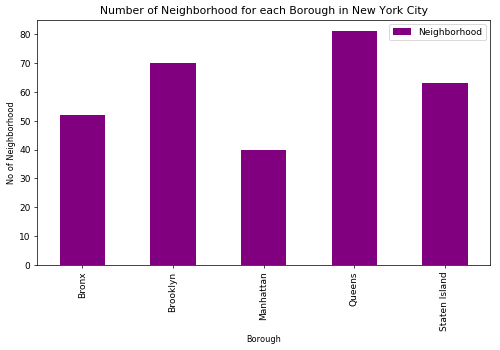

In [19]:
plt.figure(figsize=(9,5), dpi = 65)
# title
plt.title('Number of Neighborhood for each Borough in New York City')
#On x-axis
plt.xlabel('Borough', fontsize = 9)
#On y-axis
plt.ylabel('No of Neighborhood', fontsize=9)
#giving a bar plot
new_york_data.groupby('Borough')['Neighborhood'].count().plot(kind='bar',color='purple')
#legend
plt.legend()
plt.savefig('nn_4_each_bor_nyc.png')
#displays the plot
plt.show()


From the above Bar Plot, we can see that Queens has highest number of neighborhoods.


Now will collect Indian resturants for each Neighborhood.

In [20]:
column_names=['Borough', 'Neighborhood', 'ID','Name']
indian_rest_ny=pd.DataFrame(columns=column_names)
count=1
for row in new_york_data.values.tolist():
    Borough, Neighborhood, Latitude, Longitude=row
    venues = get_all_venues(Latitude,Longitude)
    indian_resturants=venues[venues['Category']=='Indian Restaurant']   
    print('(',count,'/',len(new_york_data),')','Indian Resturants in '+Neighborhood+', '+Borough+':'+str(len(indian_resturants)))
    for resturant_detail in indian_resturants.values.tolist():
        id, name , category=resturant_detail
        indian_rest_ny = indian_rest_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name
                                               }, ignore_index=True)
    count+=1
    

( 1 / 306 ) Indian Resturants in Wakefield, Bronx:0
( 2 / 306 ) Indian Resturants in Co-op City, Bronx:0
( 3 / 306 ) Indian Resturants in Eastchester, Bronx:0
( 4 / 306 ) Indian Resturants in Fieldston, Bronx:0
( 5 / 306 ) Indian Resturants in Riverdale, Bronx:0
( 6 / 306 ) Indian Resturants in Kingsbridge, Bronx:0
( 7 / 306 ) Indian Resturants in Marble Hill, Manhattan:0
( 8 / 306 ) Indian Resturants in Woodlawn, Bronx:1
( 9 / 306 ) Indian Resturants in Norwood, Bronx:0
( 10 / 306 ) Indian Resturants in Williamsbridge, Bronx:0
( 11 / 306 ) Indian Resturants in Baychester, Bronx:0
( 12 / 306 ) Indian Resturants in Pelham Parkway, Bronx:0
( 13 / 306 ) Indian Resturants in City Island, Bronx:0
( 14 / 306 ) Indian Resturants in Bedford Park, Bronx:0
( 15 / 306 ) Indian Resturants in University Heights, Bronx:0
( 16 / 306 ) Indian Resturants in Morris Heights, Bronx:0
( 17 / 306 ) Indian Resturants in Fordham, Bronx:0
( 18 / 306 ) Indian Resturants in East Tremont, Bronx:0
( 19 / 306 ) Ind

We have gotten list of all the indian resturants in new york city , Let's analyze it.

In [21]:
indian_rest_ny.head()

,Borough,Neighborhood,ID,Name
0,Bronx,Woodlawn,4c0448d9310fc9b6bf1dc761,Curry Spot
1,Bronx,Parkchester,4c194631838020a13e78e561,Melanies Roti Bar And Grill
2,Bronx,Spuyten Duyvil,4c04544df423a593ac83d116,Cumin Indian Cuisine
3,Bronx,Concourse,551b7f75498e86c00a0ed2e1,Hungry Bird
4,Bronx,Unionport,4c194631838020a13e78e561,Melanies Roti Bar And Grill


In [22]:
indian_rest_ny.shape

(141, 4)

We have seen that there are 140 Indian Resturants across New York City from above result.

Create a BAR PLOT to show Number of Indian Resturants for each Borough in New York City.

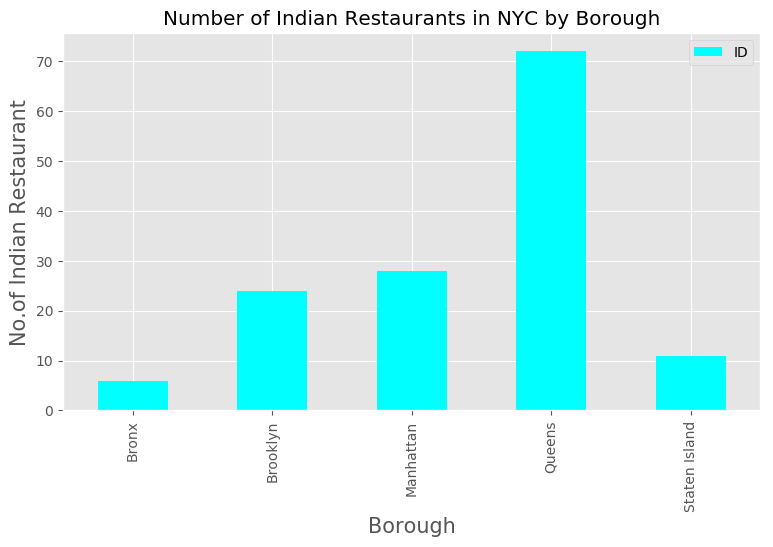

In [23]:
from matplotlib import pyplot as plt
plt.style.use('ggplot')

plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Indian Restaurants in NYC by Borough')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('No.of Indian Restaurant', fontsize=15)
#giving a bar plot
indian_rest_ny.groupby('Borough')['ID'].count().plot(kind='bar',color ='cyan')
#legend
plt.legend()
#displays the plot
plt.show()

From the above Bar Plot, we can see that Queens has highest number of Indian resturants.

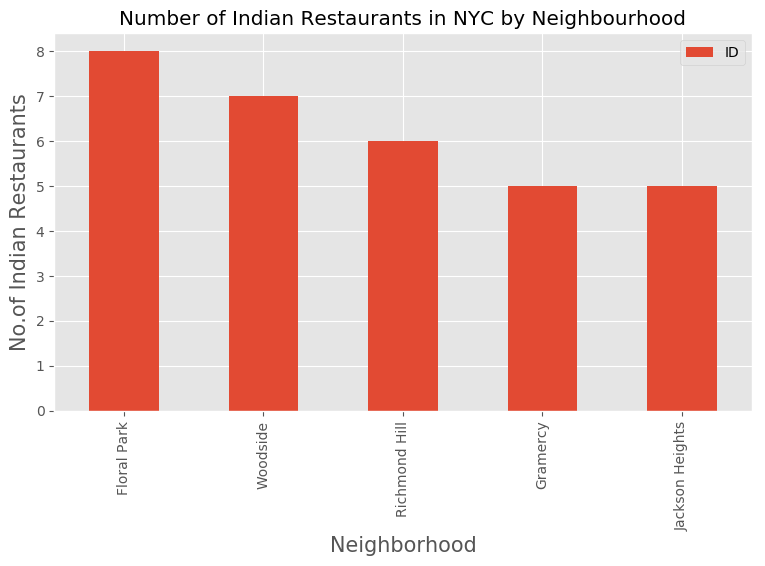

In [24]:
from matplotlib import pyplot as plt
plt.style.use('ggplot')

plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Indian Restaurants in NYC by Neighbourhood')
#On x-axis
plt.xlabel('Neighborhood', fontsize = 15)
#On y-axis
plt.ylabel('No.of Indian Restaurants', fontsize=15)
#giving a bar plot
indian_rest_ny.groupby('Neighborhood')['ID'].count().nlargest(5).plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

In [25]:
indian_rest_ny[indian_rest_ny['Neighborhood']=='Floral Park']

,Borough,Neighborhood,ID,Name
98,Queens,Floral Park,527ffc0811d2d329d5e49abd,Jackson Diner
99,Queens,Floral Park,4e4e3e22bd4101d0d7a5c2d1,Kerala Kitchen
100,Queens,Floral Park,4b647b56f964a520c4b62ae3,Usha Foods & Usha Sweets
101,Queens,Floral Park,4b787c49f964a5209cd12ee3,Santoor Indian Restaurant
102,Queens,Floral Park,4c0c01e0bbc676b00d6b4cd5,Mumbai Xpress
103,Queens,Floral Park,4c76ff35a5676dcb72671721,Flavor Of India
104,Queens,Floral Park,4df0f39dd4c04d0392c853ea,Sagar Chinese
105,Queens,Floral Park,4e6bfe1c7d8b2c711b17bbe5,Surya sweets and snacks


We can see that, Floral Park in Queens has the highest number of Indian Resturants with a total count of 10.


Will get the ranking of each resturant for further analysis.

In [26]:
# prepare neighborhood list that contains indian resturants
column_names=['Borough', 'Neighborhood', 'ID','Name','Likes','Rating','Tips']
indian_rest_stats_ny=pd.DataFrame(columns=column_names)
count=1


for row in indian_rest_ny.values.tolist():
    Borough,Neighborhood,ID,Name=row

    # prepare neighborhood list that contains indian resturants
column_names=['Borough', 'Neighborhood', 'ID','Name','Likes','Rating','Tips']
indian_rest_stats_ny=pd.DataFrame(columns=column_names)
count=1


for row in indian_rest_ny.values.tolist():
    Borough,Neighborhood,ID,Name=row
    try:
        venue_details=get_venue_details(ID)
        print(venue_details)
        id,name,likes,rating,tips=venue_details.values.tolist()[0]
    except (IndexError, KeyError) as e:
        print('No data available for id=',ID)
        # we will assign 0 value for these resturants as they may have been 
        #recently opened or details does not exist in FourSquare Database
        id,name,likes,rating,tips=[0]*5
    print('(',count,'/',len(indian_rest_ny),')','processed')
    indian_rest_stats_ny = indian_rest_stats_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name,
                                                'Likes' : likes,
                                                'Rating' : rating,
                                                'Tips' : tips
                                               }, ignore_index=True)
    count+=1

                         ID        Name  Likes  Rating  Tips
0  4c0448d9310fc9b6bf1dc761  Curry Spot      5     7.8    10
( 1 / 141 ) processed
                         ID                         Name  Likes  Rating  Tips
0  4c194631838020a13e78e561  Melanies Roti Bar And Grill      3     6.0     2
( 2 / 141 ) processed
                         ID                  Name  Likes  Rating  Tips
0  4c04544df423a593ac83d116  Cumin Indian Cuisine     13     6.0     9
( 3 / 141 ) processed
                         ID         Name  Likes  Rating  Tips
0  551b7f75498e86c00a0ed2e1  Hungry Bird      8     6.8     3
( 4 / 141 ) processed
                         ID                         Name  Likes  Rating  Tips
0  4c194631838020a13e78e561  Melanies Roti Bar And Grill      3     6.0     2
( 5 / 141 ) processed
                         ID       Name  Likes  Rating  Tips
0  4b5a4dc8f964a520a2bb28e3  Taj Mahal     38     8.0    26
( 6 / 141 ) processed
                         ID          Name  Likes

In [27]:
#Indian Restsaurants dataframe
indian_rest_stats_ny.head()

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
0,Bronx,Woodlawn,4c0448d9310fc9b6bf1dc761,Curry Spot,5,7.8,10
1,Bronx,Parkchester,4c194631838020a13e78e561,Melanies Roti Bar And Grill,3,6.0,2
2,Bronx,Spuyten Duyvil,4c04544df423a593ac83d116,Cumin Indian Cuisine,13,6.0,9
3,Bronx,Concourse,551b7f75498e86c00a0ed2e1,Hungry Bird,8,6.8,3
4,Bronx,Unionport,4c194631838020a13e78e561,Melanies Roti Bar And Grill,3,6.0,2


In [28]:
indian_rest_stats_ny.shape

(141, 7)

In [29]:
indian_rest_ny.shape

(141, 4)

We got data for all resturants lets save this data to a csv sheet. 

In case we by mistake modify it. As the number of calls to get details for venue are premium call and have limit of 500 per day, we will refer to saved data sheet csv if required.

In [30]:
indian_rest_stats_ny.to_csv('indian_rest_stats_ny.csv', index=False)

In [31]:
indian_rest_stats_ny_csv=pd.read_csv('indian_rest_stats_ny.csv')

In [32]:
indian_rest_stats_ny_csv.shape

(141, 7)

In [33]:
indian_rest_stats_ny_csv.head()

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
0,Bronx,Woodlawn,4c0448d9310fc9b6bf1dc761,Curry Spot,5,7.8,10
1,Bronx,Parkchester,4c194631838020a13e78e561,Melanies Roti Bar And Grill,3,6.0,2
2,Bronx,Spuyten Duyvil,4c04544df423a593ac83d116,Cumin Indian Cuisine,13,6.0,9
3,Bronx,Concourse,551b7f75498e86c00a0ed2e1,Hungry Bird,8,6.8,3
4,Bronx,Unionport,4c194631838020a13e78e561,Melanies Roti Bar And Grill,3,6.0,2


In [34]:
indian_rest_stats_ny.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 141 entries, 0 to 140
Data columns (total 7 columns):
Borough         141 non-null object
Neighborhood    141 non-null object
ID              141 non-null object
Name            141 non-null object
Likes           141 non-null object
Rating          141 non-null float64
Tips            141 non-null object
dtypes: float64(1), object(6)
memory usage: 7.8+ KB


The Data type of 'Likes' and 'Tips' are of type 'String'. we will convert them into type 'Float' for further analysis.

In [35]:
indian_rest_stats_ny['Likes']=indian_rest_stats_ny['Likes'].astype('float64')
indian_rest_stats_ny['Tips']=indian_rest_stats_ny['Tips'].astype('float64')

In [36]:
indian_rest_stats_ny.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 141 entries, 0 to 140
Data columns (total 7 columns):
Borough         141 non-null object
Neighborhood    141 non-null object
ID              141 non-null object
Name            141 non-null object
Likes           141 non-null float64
Rating          141 non-null float64
Tips            141 non-null float64
dtypes: float64(3), object(4)
memory usage: 7.8+ KB


In [37]:
# Resturant with maximum Likes
indian_rest_stats_ny.iloc[indian_rest_stats_ny['Likes'].idxmax()]

Borough                        Manhattan
Neighborhood                    Gramercy
ID              4a12eb1ff964a52099771fe3
Name                               Dhaba
Likes                                497
Rating                               8.3
Tips                                 164
Name: 46, dtype: object

In [38]:
# Resturant with maximum Rating
indian_rest_stats_ny.iloc[indian_rest_stats_ny['Rating'].idxmax()]

Borough                           Queens
Neighborhood                     Astoria
ID              4aa56c81f964a5204e4820e3
Name                 Seva Indian Cuisine
Likes                                239
Rating                                 9
Tips                                 133
Name: 49, dtype: object

In [39]:
# Resturant with maximum Tips
indian_rest_stats_ny.iloc[indian_rest_stats_ny['Tips'].idxmax()]

Borough                        Manhattan
Neighborhood                    Gramercy
ID              4a12eb1ff964a52099771fe3
Name                               Dhaba
Likes                                497
Rating                               8.3
Tips                                 164
Name: 46, dtype: object

In [40]:
ny_neighborhood_stats=indian_rest_stats_ny.groupby('Neighborhood',as_index=False).mean()[['Neighborhood','Rating']]
ny_neighborhood_stats.columns=['Neighborhood','Average Rating']

In [41]:
ny_neighborhood_stats.sort_values(['Average Rating'],ascending=False).head(10)

,Neighborhood,Average Rating
0,Astoria,9.0
12,Chelsea,8.8
27,Fort Greene,8.8
13,Clinton Hill,8.8
74,West Village,8.7
55,Prospect Lefferts Gardens,8.7
54,Prospect Heights,8.7
72,Upper West Side,8.5
62,Roosevelt Island,8.5
32,Gramercy,8.4


Above are the top neighborhoods with top average rating of Indian resturants.

Similarly we will find the average rating of Indian Resturants for each Borough.

In [42]:
ny_borough_stats=indian_rest_stats_ny.groupby('Borough',as_index=False).mean()[['Borough','Rating']]
ny_borough_stats.columns=['Borough','Average Rating']

In [43]:
ny_borough_stats.sort_values(['Average Rating'],ascending=False).head()

,Borough,Average Rating
2,Manhattan,7.221429
1,Brooklyn,6.204167
0,Bronx,5.433333
3,Queens,0.125000
4,Staten Island,0.000000


Now let's visualize these average ratings restaurants.

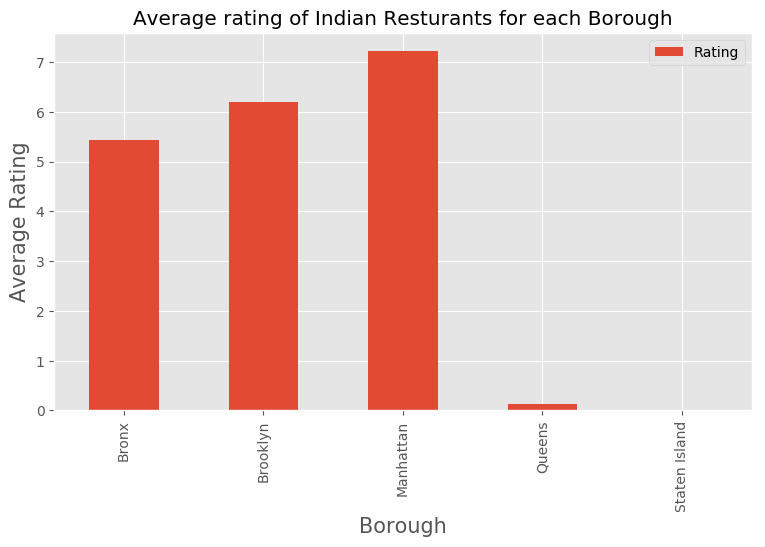

In [44]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Average rating of Indian Resturants for each Borough')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('Average Rating', fontsize=15)
#giving a bar plot
indian_rest_stats_ny.groupby('Borough').mean()['Rating'].plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

We will consider all the neighborhoods with average rating greater or equal 8.0 to visualize on map.

In [45]:
ny_neighborhood_stats=ny_neighborhood_stats[ny_neighborhood_stats['Average Rating']>=8.0]

In [46]:
ny_neighborhood_stats

,Neighborhood,Average Rating
0,Astoria,9.0
11,Central Harlem,8.0
12,Chelsea,8.8
13,Clinton Hill,8.8
18,Downtown,8.0
19,East Flatbush,8.3
27,Fort Greene,8.8
32,Gramercy,8.4
50,Ocean Hill,8.0
54,Prospect Heights,8.7


To get lonitude and latitude we will join this dataset to origianal NYC data.

In [47]:
ny_neighborhood_stats=pd.merge(ny_neighborhood_stats,new_york_data, on='Neighborhood')

In [48]:
ny_neighborhood_stats=ny_neighborhood_stats[['Borough','Neighborhood','Latitude','Longitude','Average Rating']]

In [49]:
ny_neighborhood_stats.sort_values(['Average Rating'],ascending=False).head(10)

,Borough,Neighborhood,Latitude,Longitude,Average Rating
0,Queens,Astoria,40.768509,-73.915654,9.0
2,Manhattan,Chelsea,40.744035,-74.003116,8.8
3,Staten Island,Chelsea,40.594726,-74.189560,8.8
4,Brooklyn,Clinton Hill,40.693229,-73.967843,8.8
7,Brooklyn,Fort Greene,40.688527,-73.972906,8.8
10,Brooklyn,Prospect Heights,40.676822,-73.964859,8.7
15,Manhattan,West Village,40.734434,-74.006180,8.7
11,Brooklyn,Prospect Lefferts Gardens,40.658420,-73.954899,8.7
13,Manhattan,Upper West Side,40.787658,-73.977059,8.5
12,Manhattan,Roosevelt Island,40.762160,-73.949168,8.5


In [50]:
# create map and display it
ny_map = folium.Map(location=(40.693943, -73.985880), zoom_start=12)

In [51]:
incidents = folium.map.FeatureGroup()

# loop through the 100 crimes and add each to the incidents feature group
for lat, lng, in ny_neighborhood_stats[['Latitude','Longitude']].values:
    incidents.add_child(
        folium.CircleMarker(
            [lat, lng],
            radius=10, # define how big you want the circle markers to be
            color='yellow',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6
        )
    )

Adding a new field to dataframe for the purpose of labeling.

In [52]:
ny_neighborhood_stats['Label']=ny_neighborhood_stats['Neighborhood']+', '+ny_neighborhood_stats['Borough']+'('+ny_neighborhood_stats['Average Rating'].map(str)+')'

In [53]:
# add pop-up text to each marker on the map
for lat, lng, label in ny_neighborhood_stats[['Latitude','Longitude','Label']].values:
    folium.Marker([lat, lng], popup=label).add_to(ny_map)        
# add incidents to map
ny_map.add_child(incidents)

Findings

Murray Hill, Tribeca, Midtown in Manhattan are some of the best neighborhoods for Indian cuisine.

Bronx has the lowest rated Indian Resturants in NYC.

Manhattan is the best place to stay if you prefer Indian Cuisine.

Recommendation
Midtown or Tribeca in Manhattan would be the best choice to start a restaurant given that

it is the third most populous urban area in New York City (NYC).

it has a population density of 27,826 people per square km, highest of any borough in the United States.

it has some of the top rated Indian restaurants located in that area

It has the second highest Asian ethnic minority population in NYC.